# Replication - Lung

Here we provide a notebook to replicate the application to the lung data set from R-Survival


The notebook replicates the results in:
- /out/application/lung/*

The main script can be found at: 
- /scripts/application/lung.py
- /scripts/application/lung.R

In [ ]:
# google colab specific - installing probcox
!pip3 install probcox

In [ ]:
# Modules
# =======================================================================================================================
import os
import sys
import shutil
import subprocess
import tqdm

import numpy as np
import pandas as pd

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import probcox as pcox

dtype = torch.FloatTensor

np.random.seed(7832)
torch.manual_seed(64)


In [ ]:
# Loading Data
# =======================================================================================================================
url = 'https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/ProbCox/data/application/lung.csv'

lung = pd.read_csv(url, sep=',')
surv = np.asarray(lung[['time', 'status']])
surv = np.concatenate((np.zeros((surv.shape[0], 1)), surv), axis=1)
X = np.asarray(lung.iloc[:, 3:])

surv = torch.from_numpy(surv).type(torch.FloatTensor)
X = torch.from_numpy(X).type(torch.FloatTensor)

total_obs = surv.shape[0]
batch_size = 72
total_events = torch.sum(surv[:, -1] == 1)
sampling_proportion = [total_obs, batch_size, total_events, None]

100%|██████████| 10000/10000 [01:11<00:00, 139.88it/s]


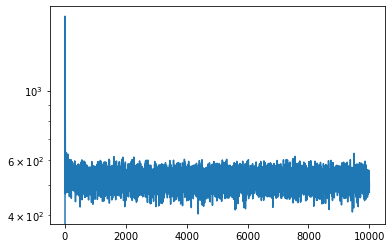

In [ ]:
# Inference
# =======================================================================================================================
run = True
eta = 1.0
while run:
    run = False
    pyro.clear_param_store()
    m = pcox.PCox(sampling_proportion=sampling_proportion)
    m.initialize(eta=eta, num_particles=5)
    loss=[0]
    for ii in tqdm.tqdm(range((10000))):
        idx = np.random.choice(range(surv.shape[0]), batch_size, replace=False)
        data=[surv[idx], X[idx]]
        if torch.sum(data[0][:, -1]) > 0:
            loss.append(m.infer(data=data))
        if loss[-1] != loss[-1]:
            eta = eta * 0.5
            run=True
            break
    g = m.return_guide()
    out = g.quantiles([0.025, 0.5, 0.975])
plt.semilogy(loss)

In [ ]:
# Prepare summary tables
# =======================================================================================================================

a = np.round(out['theta'][1].detach().numpy()[:, 0], 2)
b = np.round(torch.diag(pyro.get_param_store()['AutoMultivariateNormal.scale_tril']).detach().numpy(), 2)
c =np.sign(out['theta'][0].detach().numpy()) == np.sign(out['theta'][2].detach().numpy())
for ii in range(X.shape[1]):
    if c[ii]:
        sig = '*'
    else:
        sig = ''
    print(str(a[ii]) + sig + ', (' + str(b[ii]) + ')')

ci = pcox.metrics(surv=surv.numpy(), linpred=torch.mm(X, out['theta'][1].detach()).numpy(), processes=4).concordance()[None]
print(ci)


0.06, (0.11)
-0.53*, (0.21)
0.68*, (0.22)
0.25*, (0.11)
-0.14, (0.11)
-0.0, (0.1)
-0.17, (0.09)
[0.65391173]


In [ ]:
# load R 
%load_ext rpy2.ipython

In [ ]:
# install packages
%%R 
install.packages('survival')

library(survival)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/survival_3.2-11.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 6274168 bytes (6.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w

In [ ]:
%%R 
rm(list=ls())
library(survival)
data("lung")
lung = lung[complete.cases(lung),]
lung$status = lung$status - 1

lung$sex = lung$sex - 1
lung = data.frame(c(lung['time'], lung['status'], lung['age'], lung['sex'], lung['ph.ecog'], lung['ph.karno'], lung['pat.karno'], lung['meal.cal'],lung['wt.loss']))

standardize <- function(x){
(x - mean(x))/sqrt(var(x))
}

lung[ , c(3, 6, 7, 8, 9)] = apply(lung[ , c(3, 6, 7, 8, 9)], 2, standardize)

m = coxph(Surv(time, status) ~., data=lung)
summary(m)



Call:
coxph(formula = Surv(time, status) ~ ., data = lung)

  n= 167, number of events= 120 

              coef exp(coef) se(coef)      z Pr(>|z|)   
age        0.09951   1.10463  0.10684  0.931  0.35168   
sex       -0.55362   0.57487  0.20159 -2.746  0.00603 **
ph.ecog    0.73953   2.09496  0.22499  3.287  0.00101 **
ph.karno   0.28673   1.33207  0.14353  1.998  0.04575 * 
pat.karno -0.18237   0.83330  0.12259 -1.488  0.13685   
meal.cal   0.01172   1.01179  0.10725  0.109  0.91298   
wt.loss   -0.18998   0.82698  0.10390 -1.828  0.06748 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
age          1.1046     0.9053    0.8959    1.3619
sex          0.5749     1.7395    0.3872    0.8534
ph.ecog      2.0950     0.4773    1.3479    3.2560
ph.karno     1.3321     0.7507    1.0054    1.7648
pat.karno    0.8333     1.2001    0.6553    1.0596
meal.cal     1.0118     0.9883    0.8200    1.2485
wt.loss      0.8270     1